# Fourth Classifier

This time, classify the data *only* using flag and ethnicity data.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(context='talk')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 343)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(flag_cols | ethnicity_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 230)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.688764705882353


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.500000,0.929825,1.00,0.333333,0.647059
1,0.500000,0.929825,1.00,0.333333,0.661765
2,0.500000,0.929825,1.00,0.333333,0.653595
3,0.500000,0.929825,1.00,0.333333,0.496732
4,0.500000,0.929825,1.00,0.333333,0.565359
5,0.500000,0.929825,1.00,0.333333,0.686275
6,0.800000,0.964912,1.00,0.666667,0.785948
7,0.666667,0.947368,1.00,0.500000,0.870915
8,0.000000,0.857143,0.96,0.000000,0.810000
9,0.000000,0.890909,0.98,0.000000,0.710000


flag_Juvenile             0.101235
flag_Traveling            0.076629
flag_Foreign Providers    0.061865
ethnicity_Ebony           0.053892
ethnicity_White           0.038140
flag_Multiple Girls       0.033242
ethnicity_Latina          0.031464
ethnicity_Indian          0.030688
ethnicity_Asian           0.024761
ethnicity_French          0.024024
ethnicity_Rican           0.023287
ethnicity_Dominican       0.021453
ethnicity_Caucasian       0.018154
ethnicity_Romanian        0.016326
ethnicity_Brazilian       0.015100
flag_Massage Parlor       0.013386
ethnicity_Spanish         0.011827
ethnicity_Polish          0.011551
ethnicity_Black           0.010853
ethnicity_Latin           0.010194
dtype: float64


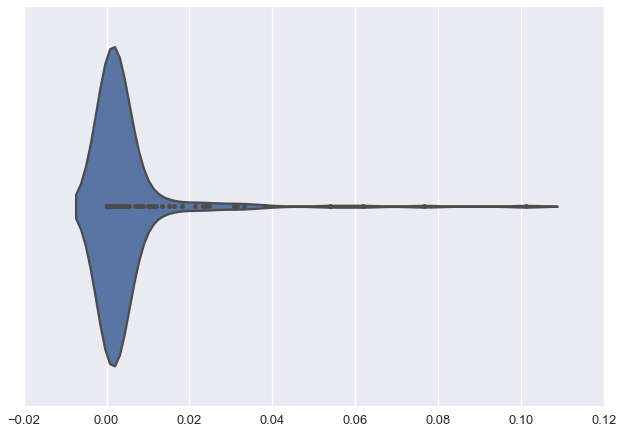

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

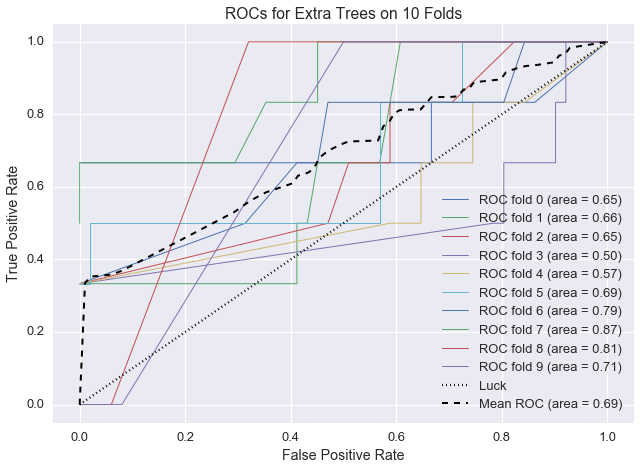

In [9]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [10]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [11]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.6936666666666667


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.500000,0.929825,1.00,0.333333,0.658497
1,0.500000,0.929825,1.00,0.333333,0.612745
2,0.500000,0.929825,1.00,0.333333,0.650327
3,0.500000,0.929825,1.00,0.333333,0.483660
4,0.500000,0.929825,1.00,0.333333,0.669935
5,0.666667,0.947368,1.00,0.500000,0.678105
6,0.800000,0.964912,1.00,0.666667,0.785948
7,0.800000,0.964912,1.00,0.666667,0.877451
8,0.000000,0.875000,0.98,0.000000,0.810000
9,0.000000,0.890909,0.98,0.000000,0.710000


flag_Juvenile             0.114407
flag_Traveling            0.088862
flag_Foreign Providers    0.077414
ethnicity_Ebony           0.058210
ethnicity_White           0.036166
ethnicity_Latina          0.034660
flag_Multiple Girls       0.033444
ethnicity_Indian          0.031501
ethnicity_Asian           0.026683
ethnicity_French          0.025758
ethnicity_Rican           0.024605
ethnicity_Dominican       0.018171
ethnicity_Latin           0.015574
ethnicity_Brazilian       0.014190
flag_Massage Parlor       0.011385
ethnicity_Spanish         0.011239
ethnicity_Romanian        0.009764
flag_URL Embedding        0.009515
ethnicity_Russian         0.009426
ethnicity_Black           0.008402
dtype: float64


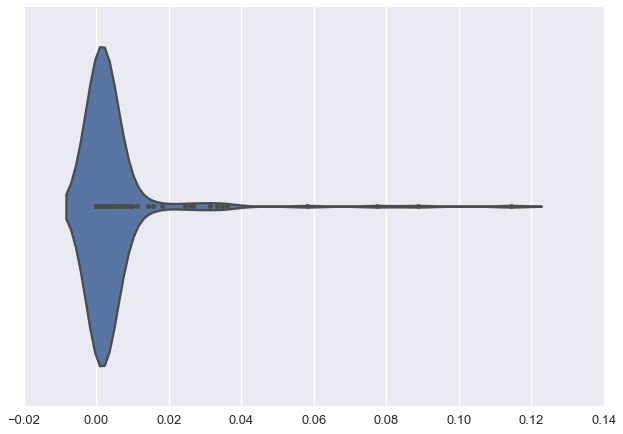

In [12]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

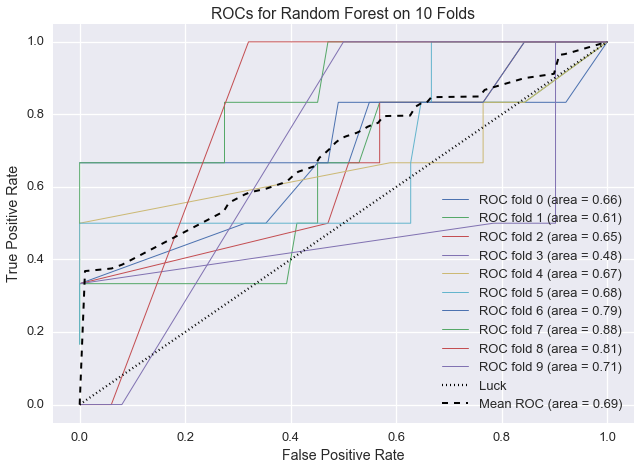

In [13]:
draw_rocs(this_metrics, 'Random Forest')